## Import thư viện

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# TRAIN
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv('data/GlobalWeatherRepository.csv')
print(df.head())

       country     location_name  latitude  longitude        timezone  \
0  Afghanistan             Kabul     34.52      69.18      Asia/Kabul   
1      Albania            Tirana     41.33      19.82   Europe/Tirane   
2      Algeria           Algiers     36.76       3.05  Africa/Algiers   
3      Andorra  Andorra La Vella     42.50       1.52  Europe/Andorra   
4       Angola            Luanda     -8.84      13.23   Africa/Luanda   

   last_updated_epoch      last_updated  temperature_celsius  \
0          1715849100  2024-05-16 13:15                 26.6   
1          1715849100  2024-05-16 10:45                 19.0   
2          1715849100  2024-05-16 09:45                 23.0   
3          1715849100  2024-05-16 10:45                  6.3   
4          1715849100  2024-05-16 09:45                 26.0   

   temperature_fahrenheit condition_text  ...  air_quality_PM2.5  \
0                    79.8  Partly Cloudy  ...                8.4   
1                    66.2  Partly cloudy

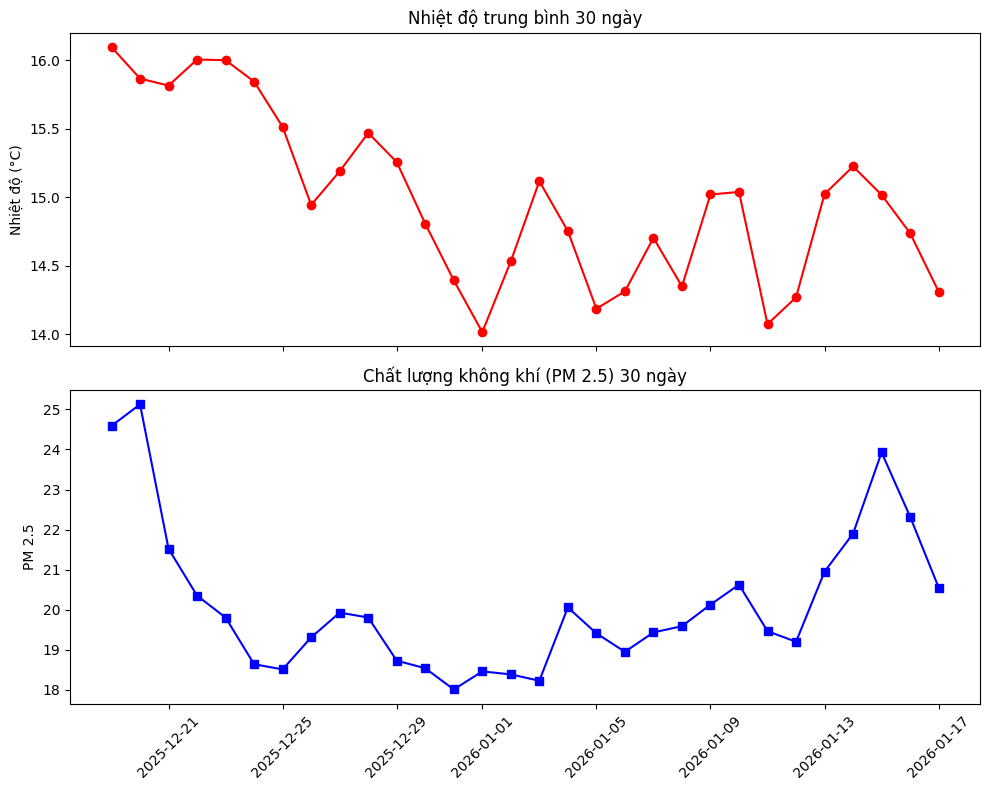

In [109]:
df['last_updated'] = pd.to_datetime(df['last_updated'])
daily_stats = df.groupby(df['last_updated'].dt.date).mean(numeric_only=True).tail(30)

# LẤY THEO KHU VỰC
region = 'Vietnam'
df = df[(df['country'] == region) & (df['location_name'] == "Hanoi")]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax1.plot(daily_stats.index, daily_stats['temperature_celsius'], 'r-o')
ax1.set_ylabel('Nhiệt độ (°C)')
ax1.set_title('Nhiệt độ trung bình 30 ngày')

ax2.plot(daily_stats.index, daily_stats['air_quality_PM2.5'], 'b-s')
ax2.set_ylabel('PM 2.5')
ax2.set_title('Chất lượng không khí (PM 2.5) 30 ngày')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

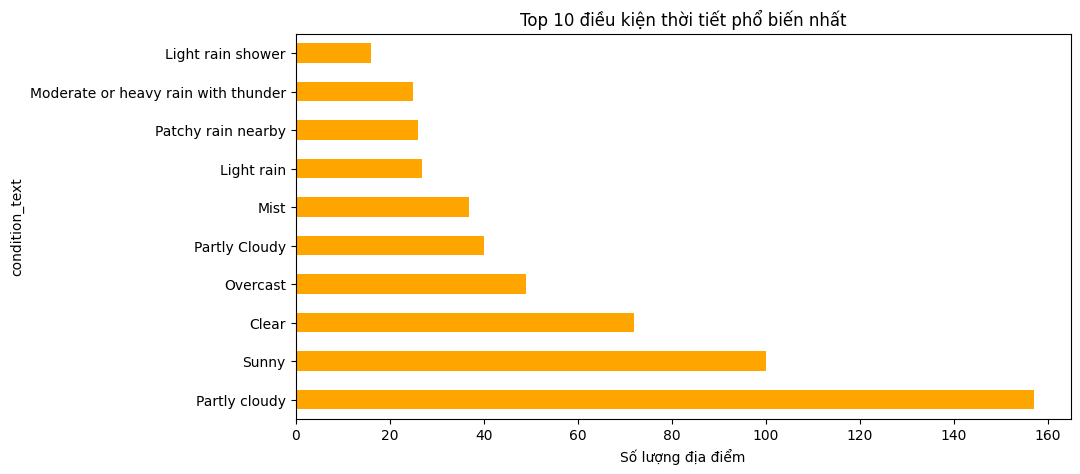

In [110]:
# Đếm số lần xuất hiện của các loại thời tiết
condition_counts = df['condition_text'].value_counts().head(10)

# Vẽ biểu đồ cột
condition_counts.plot(kind='barh', color='orange', figsize=(10, 5))
plt.title('Top 10 điều kiện thời tiết phổ biến nhất')
plt.xlabel('Số lượng địa điểm')
plt.show()

## Mô hình dự đoán

In [111]:
# TRAIN MODEL
df['hour'] = df['last_updated'].dt.hour
features = ['latitude', 'humidity', 'pressure_mb', 'wind_kph', 'cloud', 'hour']
# data = df.sort_values('last_updated').tail(10000)
data = df.sort_values('last_updated')

X = data[features]
y = data['temperature_celsius']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42) # n_estimators là số cây trong rừng, random_state để tái lập kết quả
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}°C | R²: {r2:.2f}")

RMSE: 1.94°C | R²: 0.86


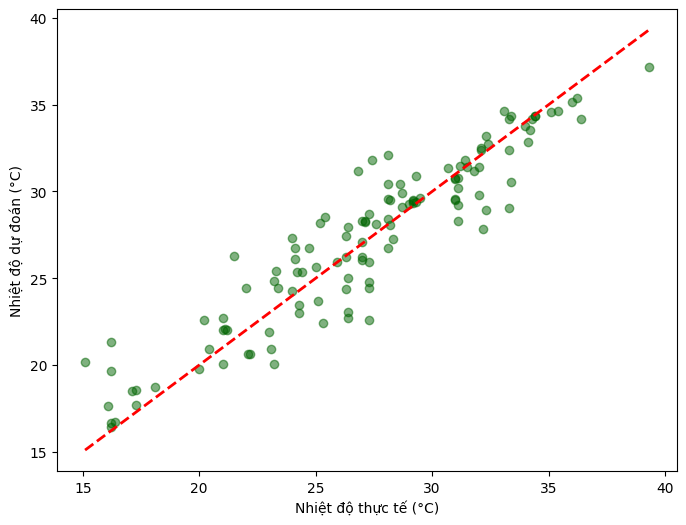

In [112]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='darkgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.xlabel('Nhiệt độ thực tế (°C)')
plt.ylabel('Nhiệt độ dự đoán (°C)')
plt.show()

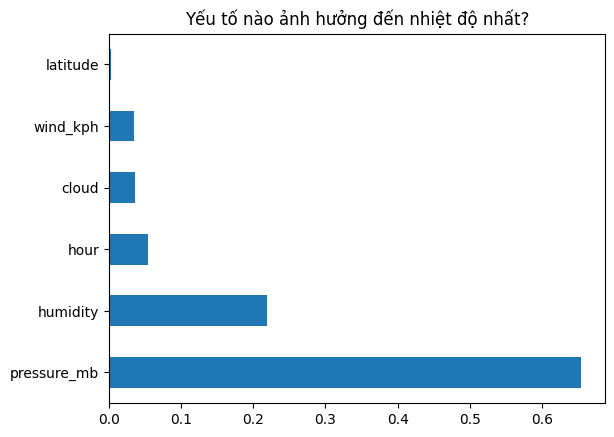

In [113]:
import pandas as pd
feat_importances = pd.Series(model.feature_importances_, index=features)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Yếu tố nào ảnh hưởng đến nhiệt độ nhất?')
plt.show()

In [ ]:
# Dự đoán nhiệt độ mới dùng dữ liệu realtim của open-metro
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

LAT, LON = 21.02, 105.83  # Tọa độ Hà Nội
url = f"https://api.open-meteo.com/v1/forecast?latitude={LAT}&longitude={LON}&current=relative_humidity_2m,surface_pressure,wind_speed_10m,cloud_cover&timezone=auto"


response = requests.get(url)
data_json = response.json()
current = data_json['current']
new_data = pd.DataFrame([{
    'latitude': LAT,
    'humidity': current['relative_humidity_2m'],
    'pressure_mb': current['surface_pressure'],
    'wind_kph': current['wind_speed_10m'] * 3.6,  # m/s to km/h
    'cloud': current['cloud_cover'],
    'hour': datetime.now().hour
}])
new_data

predictions = model.predict(new_data)
print(f"Dự đoán nhiệt độ (trung bình): {predictions[0]:.2f}°C")
print(f"Dự đoán nhiệt độ (min): {(predictions[0] - rmse):.2f}°C")
print(f"Dự đoán nhiệt độ (max): {(predictions[0] + rmse):.2f}°C")

Dự đoán nhiệt độ (trung bình): 24.68°C
Dự đoán nhiệt độ (min): 22.75°C
Dự đoán nhiệt độ (max): 26.62°C
